In [1]:
import rebound 
print(rebound.__build__)
import numpy as np
import ctypes
from ctypes import POINTER, c_double, c_int,byref
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

Nov 12 2018 18:30:18


In [2]:
def sim_copy(self):
    """
    Deep copy of a simulation.
    """
    self.save("tmp.bin")
    return rebound.Simulation.from_file("tmp.bin")
    sim2 = rebound.Simulation()
    for i in range(self.N):
        sim2.add(self.particles[i])
    sim2.t = self.t
    sim2.dt = self.dt
    return sim2
rebound.Simulation.copy = sim_copy

In [3]:
def diffsim(sim1,sim2):
    """
    Returns a meassure for the difference between two simulations.
    """
    m = 0.
    for i in range(sim1.N):
        m = max(m,abs(sim1.particles[i].x-sim2.particles[i].x))
        m = max(m,abs(sim1.particles[i].y-sim2.particles[i].y))
        m = max(m,abs(sim1.particles[i].z-sim2.particles[i].z))
        m = max(m,abs(sim1.particles[i].vx-sim2.particles[i].vx))
        m = max(m,abs(sim1.particles[i].vy-sim2.particles[i].vy))
        m = max(m,abs(sim1.particles[i].vz-sim2.particles[i].vz))
    return m

In [4]:
mercury = ctypes.cdll.LoadLibrary("../mercury/mercury.so")
def mercury_step(self,rcrit=None,algor=1):
    """
    Monkey patch, allowing a REBOUND simulation to call a Mercury integrator
    """
    if self.G!=1.:
        raise ValueError("G must be set to 1.")
    if self.N<2:
        raise ValueError("Number of particles must be > 1.")
    if self.particles[0].m!=1.:
        raise ValueError("Mass of central object must be equal to 1.")
        
    nbod = c_int(self.N)
    nbig = nbod
    NMESS = 1 # number of messages
    CMAX = 1 # number of close encounter minima monitored simultaneously 
    if algor==1:
        step = mercury.mdt_mvsp_

    elif algor==10:
        step = mercury.mdt_hyp_
        if rcrit is None:
            raise ValueError("rcrit must be set for hybrid integrator.")
    else:
        raise ValueError("Integrator not implemented")
              
    step.argtypes = [
        POINTER(c_double), # real*8              time 
        POINTER(c_double), # real*8              tstart
        POINTER(c_double), # real*8              h0
        POINTER(c_double), # real*8              tol
        POINTER(c_double), # real*8              rmax
        POINTER(c_double*3), # real*8(3)           en
        POINTER(c_double*3), # real*8(3)           am
        POINTER(c_double*3), # real*8(3)           jcen
        POINTER(c_double), # real*8              rcen
        POINTER(c_int), # integer             nbod
        POINTER(c_int), # integer             nbig
        POINTER(c_double*nbod.value), # real*8(nbod)        m
        POINTER((c_double*3)*nbod.value), # real*8(3,nbod)      x
        POINTER((c_double*3)*nbod.value), # real*8(3,nbod)      v
        POINTER((c_double*3)*nbod.value), # real*8(3,nbod)      s
        POINTER(c_double*nbod.value), # real*8(nbod)        rphys
        POINTER(c_double*nbod.value), # real*8(nbod)        rcrit
        POINTER(c_double*nbod.value), # real*8(nbod)        rce
        POINTER(c_int), # integer(nbod)       stat
        POINTER((c_double*4)*nbod.value), # real*8(4,nbod)      ngf
        POINTER(c_int), # integer             algor
        POINTER(c_int*8),# integer(8)          opt
        POINTER(c_int), # integer             dtflag
        POINTER(c_int), # integer             ngflag
        POINTER(c_int), # integer             opflag
        POINTER(c_int), # integer             colflag
        POINTER(c_int), # integer             nclo
        POINTER(c_int*CMAX), # integer(CMAX)       iclo
        POINTER(c_int*CMAX), # integer(CMAX)       jclo
        POINTER(c_double*CMAX), # real*8(CMAX)        dclo
        POINTER(c_double*CMAX), # real*8(CMAX)        tclo
        POINTER(c_double*CMAX), # real*8(CMAX)        ixvclo
        POINTER(c_double*CMAX), # real*8(CMAX)        jxvclo
        POINTER(c_int*NMESS),# integer(NMESS)     lmem
        ]

    time = c_double(0.)
    tstart = c_double(0.)
    h0 = c_double(self.dt)
    tol = c_double(1e-16)
    rmax = c_double(100.)
    DoubleArray3 = c_double * 3
    en = DoubleArray3(0.,0.,0.)
    am = DoubleArray3(0.,0.,0.)
    jcen = DoubleArray3(0.,0.,0.)
    rcen = c_double(0.)
    DoubleArrayNBOD = c_double * nbod.value
    DoubleArray3NBOD = (c_double * 3)* nbod.value
    _m = []
    _x = []
    _v = []
    _s = []
    for p in self.particles:
        _m.append(p.m)
        _x.append(DoubleArray3(p.x,p.y,p.z))
        _v.append(DoubleArray3(p.vx,p.vy,p.vz))
        _s.append(DoubleArray3(0.,0.,0.))
    m = DoubleArrayNBOD(*_m)
    x = DoubleArray3NBOD(*_x)
    v = DoubleArray3NBOD(*_v)
    s = DoubleArray3NBOD(*_s)
    rphys = DoubleArrayNBOD(*[0. for i in range(nbod.value)])
    if rcrit is None:
        rcrit = DoubleArrayNBOD(*[0. for i in range(nbod.value)])
    else:
        rcrit = DoubleArrayNBOD(*rcrit) 
    rce = DoubleArrayNBOD(*[0. for i in range(nbod.value)])
    stat = c_int(0)
    DoubleArray4 = (c_double * 4)
    DoubleArray4NBOD = (c_double * 4) * nbod.value
    ngf = DoubleArray4NBOD(*[DoubleArray4(0,0,0,0) for i in range(nbod.value)])
    algor = c_int(algor)
    IntArray8 = c_int*8
    opt = IntArray8(0,1,1,2,0,1,0,0)
    dtflag = c_int(0)
    ngflag = c_int(0)
    opflag = c_int(0)
    colflag = c_int(0)
    nclo = c_int(1)
    iclo = (c_int*1)(0)
    jclo = (c_int*1)(0)
    dclo = (c_double*1)(0.)
    tclo = (c_double*1)(0.)
    ixvclo = (c_double*1)(0.)
    jxvclo = (c_double*1)(0.)
    lmem = (c_int*1)(0)

    step(byref(time), byref(tstart), byref(h0), byref(tol), byref(rmax), byref(en), byref(am), byref(jcen), byref(rcen),
         byref(nbod), byref(nbig), byref(m), byref(x), byref(v), byref(s), byref(rphys), byref(rcrit), byref(rce), byref(stat),
         byref(ngf), byref(algor), byref(opt), byref(dtflag), byref(ngflag), byref(opflag), byref(colflag), byref(nclo),
         byref(iclo), byref(jclo), byref(dclo), byref(tclo), byref(ixvclo), byref(jxvclo), byref(lmem))
    for i,p in enumerate(self.particles):
        self.particles[i].x = x[i][0]
        self.particles[i].y = x[i][1]
        self.particles[i].z = x[i][2]
        self.particles[i].vx = v[i][0]
        self.particles[i].vy = v[i][1]
        self.particles[i].vz = v[i][2]
    self.t += self.dt
rebound.Simulation.mercury_step = mercury_step

In [5]:
def _step_inertial(self,algo):
    dt = self.dt
    com = self.calculate_com()
    self.move_to_hel() # Mercury needs to be in hel
    if algo == "mercuryhybrid":
        self.mercury_step(rcrit=rcrit, algor=10)
    elif algo == "mercurymvs":
        self.mercury_step(algor=1)        
    elif algo == "mercurius":
        self.integrator = "mercurius"
        self.ri_mercurius.rcrit = 12
        self.ri_whfast.coordinates = "democraticheliocentric"
        self.step()
    elif algo == "whfast":
        self.integrator = "whfast"
        self.ri_whfast.coordinates = "jacobi"
        self.step()
    elif algo == "whfastcor":
        self.integrator = "whfast"
        self.ri_whfast.coordinates = "jacobi"
        self.ri_whfast.corrector = 11
        self.step()
    elif algo == "whfastdh":
        self.integrator = "whfast"
        self.ri_whfast.coordinates = "democraticheliocentric"
        self.step()    
    elif algo == "ias15":
        self.integrator = "ias15"
        self.integrate(self.t+self.dt,exact_finish_time=1)            
        self.dt = dt
    else:
        raise ValueError("Not defined")

    self.move_to_com()
    for i in range(sim.N):
        self.particles[i].x += com.x + dt*com.vx
        self.particles[i].y += com.y + dt*com.vy
        self.particles[i].z += com.z + dt*com.vz
        self.particles[i].vx += com.vx
        self.particles[i].vy += com.vy
        self.particles[i].vz += com.vz
rebound.Simulation.step_inertial = _step_inertial    

In [6]:
def setup_sim():
    sim = rebound.Simulation()
    sim.add(m=1)
    sim.add(a=1,e=0.1,f=0.9,omega=4.9,m=0.001)
    sim.add(a=1.1,omega=0.3,f=0.5,e=0.2,m=0.001)
    sim.dt = 0.025
    return sim
# calculate mercurius rcrit, then use it later for mercury
sim = setup_sim()
sim.step_inertial("mercurius")
rcrit_mercurius = [sim.ri_mercurius._rhill[i] for i in range(sim.N)]
rcrit = rcrit_mercurius
rcrit

[0.0, 0.8320335292207616, 0.9179505805957162]

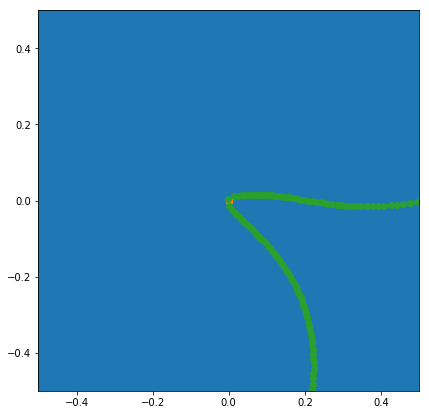

In [7]:
"""Plotting the test orbit"""
fig, ax = plt.subplots(1,1,figsize=(7,7))        

sim = setup_sim()
patches = [[] for i in range(sim.N)]
steps = 300
xyz = np.zeros((steps,sim.N,3))
for k in range(steps):
    sim.step_inertial("ias15")
    for i in range(sim.N):
        refid = 1
        ref = sim.particles[refid]
        xyz[k][i] = [sim.particles[i].x-ref.x, sim.particles[i].y-ref.y, sim.particles[i].z-ref.z]
        if rcrit[i]>0.:
            circle = Circle((xyz[k][i][0], xyz[k][i][1]), rcrit[i])
            patches[i].append(circle)
        
for i in range(sim.N):        
    p = PatchCollection(patches[i], alpha=0.02)
    ax.add_collection(p)

ax.set_aspect("equal")
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.5,0.5])
for i in range(sim.N):
    ax.scatter(xyz[:,i,0],xyz[:,i,1]);

In [8]:
def _get_min_distance(self):
    m = 0.
    for i in range(self.N):
        for j in range(i+1,self.N):
            dx = self.particles[i].x - self.particles[j].x
            dy = self.particles[i].y - self.particles[j].y
            dz = self.particles[i].z - self.particles[j].z
            s = dx**2+dy**2+dz**2
            if m>s or m==0.:
                m = s 
    return np.sqrt(s)
rebound.Simulation.get_min_distance = _get_min_distance

In [9]:
def symplecticity(sim,algo):
    Ndim = sim.N*6
    Omega1 = np.concatenate((np.zeros((Ndim//2,Ndim//2)),np.identity(Ndim//2)),axis=1)
    Omega2 = np.concatenate((-np.identity(Ndim//2),np.zeros((Ndim//2,Ndim//2))),axis=1)
    Omega = np.concatenate((Omega1,Omega2))
    J = np.zeros((Ndim,Ndim))
    delta = 1e-7

    data0 = np.zeros(Ndim)
    data = np.zeros(Ndim) # will be reused

    sim_0 = sim.copy()
    sim_0.step_inertial(algo)
    sim_0.serialize_particle_data(xyzvxvyvz=data0)

    for i in range(Ndim):
        sim_p = sim.copy()
        
        sim_p.serialize_particle_data(xyzvxvyvz=data)
        
        # Juggling indicies to convert from xyzxyzvxvyvzvxvyvz to xyzvxvyvzxyzvxvyvz
        i_p = (i//3) % (Ndim//6) # particle index
        i_c = i%3 # positions
        shift = delta 
        if i>=Ndim//2:
            i_c += 3 # momenta
            shift /= sim_p.particles[i_p].m # adjust scale for momenta
        data[6*i_p+i_c] += shift
        sim_p.set_serialized_particle_data(xyzvxvyvz=data)
          
        sim_p.step_inertial(algo)
        
        sim_p.serialize_particle_data(xyzvxvyvz=data)
        data_d = data-data0
        for j in range(Ndim):
            j_p = (j//3) % (Ndim//6) # particle index
            j_c = j%3 # positions
            shift = delta 
            if j>=Ndim//2:
                j_c += 3 # momenta
                shift /= sim_p.particles[j_p].m
            J[i][j] = data_d[6*j_p+j_c]/shift   
        
    return np.sum(np.abs(np.dot(np.dot(J.T,Omega),J)-Omega))

In [10]:
algos = ["ias15","mercurius","mercuryhybrid","mercurymvs","whfast","whfastcor","whfastdh"]
steps = 300
energy = np.zeros([len(algos),steps])
symple = np.zeros([len(algos),steps])
distan = np.zeros([len(algos),steps])
times = np.zeros(steps)
simdiffias15 = np.zeros([len(algos)-1,steps])
simdiffmercu = np.zeros([len(algos)-2,steps])
sims = []
for i,algo in enumerate(algos):
    sims.append(setup_sim())
e0 = sims[0].calculate_energy()
for k in range(steps):
    for i,algo in enumerate(algos):
        symple[i,k] = symplecticity(sims[i],algo)
        sims[i].step_inertial(algo)
        energy[i,k] = np.abs((e0-sims[i].calculate_energy())/e0)
        distan[i,k] = sims[i].get_min_distance()
        times[k] = sims[i].t
        if i>0:
            simdiffias15[i-1,k] = diffsim(sims[0],sims[i])     
        if i>1:
            simdiffmercu[i-2,k] = diffsim(sims[1],sims[i])         

In [11]:
def K(r,rcrit):
    y = (r-0.1*rcrit)/(0.9*rcrit)
    if y<0.: return 0
    if y>1.: return 1.
    return 10.*y**3 - 15.*y**4 + 6*y**5
distan_mercurius = distan[1]
K_mercurius = np.zeros(steps)
for i in range(steps):
    K_mercurius[i] = K(distan_mercurius[i],np.max(rcrit))

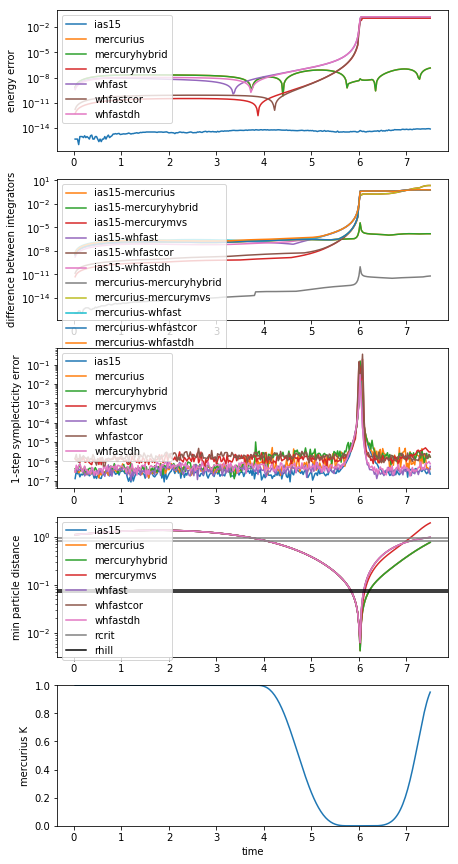

In [12]:
fig, ax = plt.subplots(5,1,figsize=(7,15))
ax[0].set_yscale("log")
for i,algo in enumerate(algos):
    ax[0].plot(times,np.maximum(energy[i,:],1e-16),label=algo)
ax[0].legend(loc="upper left");
ax[0].set_ylabel("energy error");
next(ax[1]._get_lines.prop_cycler) # skip one color
ax[1].set_yscale("log")
for i,algo in enumerate(algos):
    if i>0:
        ax[1].plot(times,simdiffias15[i-1],label=algos[0]+"-"+algo)
for i,algo in enumerate(algos):
    if i>1:
        ax[1].plot(times,simdiffmercu[i-2],label=algos[1]+"-"+algo)        
ax[1].legend(loc="upper left");
ax[1].set_ylabel("difference between integrators");
ax[2].set_yscale("log")
#ax[2].set_ylim([1e-16,1])
for i,algo in enumerate(algos):
     ax[2].plot(times,symple[i],label=algo)
ax[2].legend(loc="upper left");
ax[2].set_ylabel("1-step symplecticity error");
ax[3].set_yscale("log")
for i,algo in enumerate(algos):
     ax[3].plot(times,distan[i],label=algo)
label = "rcrit"
for r in rcrit:
    if r>0:
        ax[3].axhline(r,color="gray",label=label)
        label = None
label = "rhill"
for o in setup_sim().calculate_orbits():
    ax[3].axhline(o.rhill,color="black",label=label)
    label = None
        
ax[3].legend(loc="upper left");
ax[3].set_ylabel("min particle distance");
ax[4].set_ylim([0,1])
ax[4].plot(times,K_mercurius)
ax[4].set_ylabel("mercurius K");
ax[-1].set_xlabel("time");